## Vessel: Lesson

Imports and visualization functions

In [1]:
from IPython.display import display, HTML,clear_output

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from copy import deepcopy

import sys
sys.path.append('../../')
from chemistrylab.chem_algorithms import vessel,material


def display_side_by_side(**tables):
    """Display tables side by side to save vertical space
    Input:
        tables: name , pandas.DataFrame pairs
    """
    output = ""
    for caption, df in tables.items():
        caption = " ".join(caption.split("_"))
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
    

def plot_layers(vessels,cmap='cubehelix'):
    """Function to display the layer observations"""
    v0 = vessels[0]
    fig,axs = plt.subplots(1,len(vessels))
    if len(vessels) ==1:axs=[axs]

    cvals = (np.array([v0.material_dict[mat]._color for mat in v0.solvents]+[0.65])+0.2)%1
    im = axs[-1].imshow([cvals],cmap=cmap,vmin=0,vmax=1)
    colors = [ im.cmap(im.norm(value)) for value in cvals]
    patches = [ mpatches.Patch(color=colors[i],label= name) for i,name in enumerate(list(v0.solvents)+["air"]) ] 
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    for i,ax in enumerate(axs):
        ax.imshow((np.stack([vessels[i]._layers]*40).T[::-1] +0.2)%1,vmin=0,vmax=1,cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.legend()
        fig.tight_layout()
    plt.show()



### Overview:

In this lesson, we will be going through a class that is vital to the operation of all of our benches, the vessel class.
The source code for this can be found here: `chemistrylab/chem_algorithms/vessel.py`. The vessel class as it is named is
meant to simulate the use of any given you might find in a chemistry lad, such as a beaker or an extraction vessel.
Here we will be going through the important concepts, functions and attributes that make up the vessel class so that you
can easily use it when designing your own reactions.

If you want a more detailed look into each function of the vessel I suggest you go to our [documentation]() on the data
structure. 

The Vessel class serves as any container you might find in a lab, a beaker, a dripper, etc. The vessel class simulates and allows for any action that you might want to perform within a lab, such as draining contents, storing gasses from a reaction, performing reactions, mix, pour, etc. This is performed using an event queue, which we will look at later in this lesson. First an overview of some of the important variables that make up the vessel class:

Important Variables |Structure | Description
---|---|---
material_dict|{str(material): material, ...}|a dictionary holding all the material inside this vessel
solvents| [str(material), ...] | A list of solute names
solute_dict|{str(solute): array[len(solvents)] , ...}| dictionary that represents the solution



## An example vessel:


In [ ]:
v=vessel.Vessel("A")
H2O = material.H2O(mol=1)
Na,Cl = material.NaCl().dissolve().keys()
Na.mol=Cl.mol=1
C6H14 = material.C6H14(mol=1.0)
ether=material.DiEthylEther(mol=0.5)
dodecane = material.Dodecane(mol=2)

v.material_dict={str(Na):Na,str(Cl):Cl,str(C6H14):C6H14,str(H2O):H2O,str(dodecane):dodecane}

v.validate_solvents()
v.validate_solutes()

display_side_by_side(Materials = v.get_material_dataframe(), Solutes = v.get_solute_dataframe())

To briefly describe above, the material_dict describes the materials contained within a vessel and the quantity of that material. The material dict is a dictionary of (material.name, material instance) pairs. As for the solute dict, it represents how much each solute is dissolved in each solvent. Above we can see that each solute is dissolved in 50% water and 50% oil.


Next we will look at some of the important functions that we will need to use with the vessel class:

Important functions | Description
---|---
push_event_to_queue()|used to pass event into the vessel
validate_solvents()| Call when manually updating the material dict in order to update the solvent list
validate_solutes()| Call when manually updating the material dict in order to update the solute_dict

From the list above, the most important function is push_event_to_que(). The rest of the functions are generally handeled in the backend.

#### Event Functions
Function Name|Description
---|---
'pour by volume'|Pour from self vessel to target vessel by certain volume
'pour by percent'| Pour a fraction of all contents in one vessel into another
'drain by pixel|Drain from self vessel to target vessel by certain pixel
'mix'| Shake the vessel or let it settle
'update_layer'|Update self vessel's layer representation
'change heat'| Add or remove heat from the vessel,
'heat contact'| Connect the vessel to a reservoir for heat transfer,


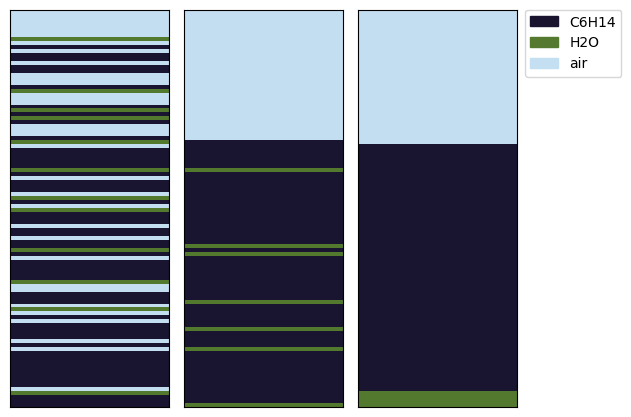

,C6H14,H2O
Na,0.802160,0.197840
Cl,0.802160,0.197840
dodecane,1.604319,0.395681
,C6H14,H2O
Na,0.798605,0.201394
Cl,0.798605,0.201394
dodecane,1.853516,0.146484
,C6H14,H2O
Na,0.674302,0.325698
Cl,0.674302,0.325698


In [13]:

    
    
v.push_event_to_queue([vessel.Event('mix',[-1],None)],0)

v2,v3 = deepcopy(v),deepcopy(v)

v2.push_event_to_queue([vessel.Event('mix',[0.02],None)])
v3.push_event_to_queue([vessel.Event('mix',[0.5],None)])


plot_layers([v,v2,v3])

display_side_by_side(
    Mixed            = v.get_solute_dataframe(), 
    Partially_settled= v2.get_solute_dataframe(), 
    Fully_Settled    = v3.get_solute_dataframe())

In [7]:
def mix(v, Vprev, v_solute, B, C, C0 , D, Spol, Lpol, S, mixing):
    """
    Calculates the positions and variances of solvent layers in a vessel, as well as the new solute amounts, based on the given inputs.

    Args:
    - v (np.ndarray): The volume of each solvent
    - Vprev (np.ndarray): The volume of each solvent on the previous iteration
    - v_solute (np.ndarray): The specific volume of each solute (litres per mol)
    - B (np.ndarray): The current positions of the solvent layers in the vessel
    - C (np.ndarray): The current variances of the solvent layers in the vessel
    - C0 (float) The current variance of solutes in the vessel
    - D (np.ndarray): The density of each solvent
    - Spol (np.ndarray): The relative polarities of the solutes
    - Lpol (np.ndarray): The relative polarities of the solvents
    - S (np.ndarray): The current amounts of solutes in each solvent layer (2D array)
    - mixing (float): The time value assigned to a fully mixed solution

    Returns:
    - layers_position (np.ndarray): An array of floats representing the new positions of the solvent layers in the vessel
    - layers_variance (np.ndarray): An array of floats representing the new variances of the solvent layers in the vessel
    - new_solute_amount (np.ndarray): An array of floats representing the new amounts of solutes in each solvent layer
    - var_layer (np.ndarray): Modified layer variances which account for the extra volume due to dissolved solutes

    Algorithm (Solvent):
    1. Using the volumes and densities of each solvent, determine where each solvent's center of mass should be at t-> inf
    2. Determine the speed in which each solvent should separate out using the densities
    3. Handle any external changes to the solving (pouring in/out) using v and Vprev
        i. Since there is an injective map between variance and time, it is easier to work with variance
            a) Initial variance is sum(v)/sqrt(12) [gaussian approximation of a uniform distribution]
            b) Final variance is vi/MINVAR -> MINVAR should probably be around sqrt(12) still (but be <=)
        ii. Pouring in a solvent should kind of mix around the solution, and since the max variance is sum(v)/sqrt(12)
            adding in dv/sqrt(12) seems reasonable
        iii. For the solvent actually being added, we can assume you are pouring into the top, so it should be mixed
            the closer to the bottom the solvent layer is. It should also be mixed more depending on how much you are adding.
        iv. If adding a solvent causes things to be mixed around a bunch, it should end up mixing the solutes too
    4. Get a time-like variable saying much each solvent is settled using the current variance (Recall the map is injective)
    5. Increment this by the mixing parameter
        i. If time is being decreased by the mixing parameter, we first set T<= Tmax so something which settled for a long time
            still mixes reasonably fast (and also as T->inf the map between variance and time gets sus cuz of floats)
    6. Use this incremented time to update your layer positions, as well as layer variances

    Algorithm (Solute):
    TODO: Write this out

    """
    
    s=C*1
    x=B*1
    # CONSTANTS
    MINVAR=np.float32(3.5)
    SCALING=np.float32(1e-2)
    t_scale = 25
    #Cmix = np.float32(2.0)
    tmix = np.float32(-1.6120857137646178)#-1.0 * np.log(Cmix * np.sqrt(2.0 * np.pi))
    tseparate = np.float32(-1.47)
    TOL=np.float32(1e-12)
    E3 = np.float32(1e-3)
    sq12 = np.float32(3.4641)

    # copy mixing for the solutes in case you need to modify it
    solute_mixing = 0
    #figure out where the gaussians should end up at T-> inf
    order=np.argsort(D)[::-1]
    Vtot= np.sum(v) #Total volume



    #Get convergence speeds based off of how different the densities are
    diff = np.zeros(D.shape[0],dtype=np.float32)
    for i in range(diff.shape[0]):
        for j in range(0, i):
            diff[j] -= (D[j] - D[i])
        for j in range(i+1, D.shape[0]):
            diff[j] -= (D[j] - D[i])
    diff = np.clip(np.abs(diff),E3,None)

    max_var = Vtot/sq12
    
    #adjust variance
    for i in range(v.shape[0]):
        # Figure out how much the volume has changed
        dv = v[i] - Vprev[i]
        # Make sure variance is at least as big as fully separated variance
        cur_var= max(s[i],v[i]/MINVAR)
        # Add some variance to each solvent
        #s+=dv/sq12
        # Extra mixing dependant on the position and how much was added
        if dv>1e-6:
            new_var = (dv/(np.abs(v[i]-dv)+TOL))*((Vtot-x[i])/sq12)
            new_var = min(max_var, max(cur_var,new_var))
            s[i]=new_var
            #TODO: Set extra mixing of solutes
            var_ratio = (new_var-cur_var)/(abs(max_var-cur_var)+TOL)
            solute_mixing = min(solute_mixing, (tmix-tseparate)*var_ratio )
        else:
            s[i] = min(max_var, s[i]+dv/MINVAR)

    #Get the mixing-time variable
    sf = v/MINVAR # final variances
    si = Vtot/sq12 # initial variances
    s=np.clip(s,sf+TOL,si-TOL)
    #ratio -> inf as t -> inf
    ratio = np.clip((si-sf)/(s-sf),1,None)

    #Elapsed time T is [0,inf) and increases monotonely with ratio
    T = np.sqrt(np.log(ratio)/2)*Vtot
    # Add any extra time
    
    ratio = np.clip(v/Vtot,0,1-E3)
    dt = mixing*diff/(1-ratio)**2*SCALING
    # Do a cap on T when mixing since you should always be able to stir the vessel
    # Even if the vessel has been settling for 100 years
    if mixing< -1e-4:
        T_max = np.float32(3.278)*dt/dt.min()
        T = (T>T_max)*T_max+(T<=T_max)*T

    T+=dt
    #Make sure Time is >= 0 (0 is fully mixed time)
    T=np.clip(T,0,None)


    #Update variance
    g = np.exp(-2*(T/Vtot)**2)
    C = sf+(si-sf)*g

    #Math for position vs time:
    #https://www.desmos.com/calculator/f5pyvybclv 

    # A are the volumes used for dissolving
    A=v[:-1]

##############################[Mixing / Separating Solutes]#######################################

    t = np.float32(-np.log(C0 * np.sqrt(2.0 * np.pi)) )

    # Mixing should always mix at least a bit   
    if mixing<0 or solute_mixing<0:
        t=min(t,tseparate)

    mixing+=solute_mixing
    # Check if fully mixed already
    if t + mixing < tmix:
        mixing = tmix - t
    t += mixing

    print(mixing)

    Scur = np.copy(S)
    # only do the calculation if there are two or more solvents
    if not ((len(A) < 2) or A.sum()-A.max()<1e-12 or abs(mixing)<1e-12):
    # Update amount of solute i in each solvent
      for i in range(S.shape[0]):

        Ssum = np.sum(Scur[i])
        if Ssum<1e-6:
            continue    

        # Calculate the relative and weighted polarity terms
        Ldif = np.float32(0)
        Ldif0 = np.float32(0)
        for j in range(Lpol.shape[0]):
            Ldif += np.abs(Spol[i] - Lpol[j])
            Ldif0 += A[j] * np.abs(Spol[i] - Lpol[j])

        # Calculate total amount of solute
        
        
        # Note A*re_weight has the same sum as A
        re_weight = (1 - (np.abs(Spol[i] - Lpol) / Ldif)) / (1 - (Ldif0) / (np.sum(A) * Ldif))
        #coeff for current timestep
        alpha = np.exp(t_scale*(tmix - t))
        #coeff for prev timestep
        beta = np.exp(t_scale*(tmix - (t - mixing)))
        # Calculate the ideal amount of solute i in each solvent for the current time step
        St = (Ssum * A / np.sum(A)) * (alpha + (1-alpha)*re_weight)
        # Calculate the ideal amount of solute i in each solvent for the previous time step
        St0 = (Ssum * A / np.sum(A)) * (beta + (1 - beta) * re_weight)
        #print(S[i],St0,St,re_weight,mixing,alpha,beta)
        if np.abs(t - mixing - tmix) > 1e-9:
            print(cosine)
            #Square of the cosine between the two distributions
            cosine = (St0*S[i]).sum()/((S[i]**2).sum()*(St**2).sum())**0.5
            # Moving backwards in time
            if mixing<0:
                #Make sure mixing always happens reasonably well
                cosine = max(cosine,1-cosine)
                S[i] = S[i]*(1-cosine) + St*cosine
            # Moving Forwards in time
            else:
                #scale cosine to be higher if you wait longer (bad approximation)
                cosine = max(min(1,cosine**1.5*(mixing*t_scale*5)**1.5),1e-2)
                # Move towards projected step St with cosine step size
                S[i] = S[i]*(1-cosine) + St*cosine
        else:
            S[i] = St

    C0 = np.float32( np.exp(-1.0 * t) / np.sqrt(2.0 * np.pi) )

    #Update layer volumes to include their dissolved solutes
    v_layer = v.copy()
    for i in range(S.shape[0]):
        for j in range(v_layer.shape[0]-1):
            vol = S[i][j]*v_solute[i]
            # Add solute volume to solvent volume
            v_layer[j]+=vol
            #reduce amount of air
            v_layer[-1]-=vol

    # Calculate final layer positions
    means = np.zeros(D.shape[0],dtype=np.float32)
    Vtot = np.float32(0)
    for i in order:
        means[i] = Vtot+v_layer[i]/2
        Vtot+=v_layer[i]

    #update positions
    c=1.2/(np.abs(means-Vtot/2)+TOL)
    c=np.clip(c,E3,30)
    f=np.log(1+(np.exp(c)-1)*np.exp(-c*T))/c
    B= means+(Vtot/2-means)*f

    # Adjust variances for dissolved volumes
    sf2 = v_layer/MINVAR 
    var_layer = sf2+(si-sf2)*g

    return B, v_layer, C,C0, S, var_layer

from chemistrylab.extract_algorithms import separate
separate.mix = mix

To visualize what we are doing above, we have several graphs:

Here we have a graph of the seperation between the oil and the water when we initially add them to our vessel

![added oil and water](../../docs/tutorial_figures/vessel/vessel_1.png)

Here we have the solution after we drain some of it (notice that the top of the vessel is now air):

![drained oil and water](../../docs/tutorial_figures/vessel/vessel_2.png)
#### The Workflow
  
  1. Agent choose action from the action space of an environment.
  2. The environment does the calculation and update and generate events.
  3. At the end of each action, if the action affect a vessel, use push_event_to_queue() to push the event into the vessel, if no event generated, call the function with events=None.
  4. With push_event_to_queue() called, events are pushed into the vessel.
  5. _update_materials is automatically called and perform events in the events_queue.
  6. Each event has a corresponding event function, it first update properties of the vessel, then loop over the materials inside the vessel by calling the corresponding event functions of each material.
  7. The materials' event function will return feedback by calling the push_event_to_queue(), which contains feedback and unfinished event 
  8. The returned feedback is added to the _feedback_queue
  9. The the _merge_event_queue() is called on _feedback_queue, which merge the events in the feedback_queue to generate a merged_queue and add default event into it, then empty the _feedback_queue
  10. Then the merged_queue will be executed and new feedback are collected and added to _feedback_queue, which will be executed with the next action. 

